# An unimodal predictor for TNBC prognosis from 3D medical image data
### Sub-title: The execution script to predict TNBC disease-free survival (DFS) using 3D medical image data
#### Description: 유방암의 3D 진단영상 데이터를 분석하여 TNBC 환자의 3년 기준 재발 예후를 예측하는 모델 구동 파이썬 스크립트 코드 입니다. 본 구동 스크립트와 함께 신규 입력 데이터의 예후를 예측할 기구축된 예측모델 (파일명: model.unimodal_MRI_TNBC_DFS_3yr.hdf5)이 동봉되어 있습니다.

### Step 1. Loading packages
>#### Description: 예측모델 구동에 필요한 패키지 전반을 로딩합니다. 아래 코드를 CTRL + Enter로 실행하십시오. 패키지가 설치되어 있지 않으면 conda install 또는 pip install 명령으로 설치하시기 바랍니다.

In [1]:
#import dependencies
import pandas as pd
import nibabel as nib
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from matplotlib import pyplot

### Step 2. Loading meta data
>#### Description: TNBC 예후를 예측할 입력데이터의 파일리스트를 로딩합니다. 파일 리스트 목록이 저장된 파일은 텍스트 형식입니다. 아래 코드에서 파일명 및 경로를 지정하십시오.
>#### 파일 리스트 목록의 컬럼양식은 다음과 같습니다:
>*[순서번호, 환자ID, nii파일이름, nii파일이_저장된_root경로, 재발예후(0 or 1), 추적관찰기간(months)]*
>#### 자세한 형식은 동봉된 예제 데이터의 양식("UC_003.nii_meta.TNBC_unimodal.txt")을 참조하시기 바랍니다.
>#### 주의: 입력 3D medical image의 형식은 (80,80,30) shape의 NIFTI (.nii) 형식 입니다. 입력데이터가 다른 파일형식이라면 유틸리티가 동봉된 유스케이스(UC_EXTRA.UTILITIES) 폴더의 프로그램들을 참조하여 NIFTI 형식으로 변환 후 본 스크립트를 구동하시기 바랍니다.

In [4]:
# load meta data
meta_filename = "UC_003.nii_meta.TNBC_unimodal.txt"

bcrDataFrame = pd.read_csv(meta_filename, sep="\t", index_col=0)

column_header_list = list(bcrDataFrame.columns)

patient_list = list(bcrDataFrame[column_header_list[0]])
nii_list = list(bcrDataFrame[column_header_list[1]])
data_root_folder = list(bcrDataFrame[column_header_list[2]])
dfs_list = list(bcrDataFrame[column_header_list[3]])
dfs_m_list = list(bcrDataFrame[column_header_list[4]])

print("#n of nii files: " + str(len(nii_list)))

#n of nii files: 423


### Step 3. Loading user input files of nifti-formatted images
>#### Description: 메타데이터 목록에서 지정되어 있는 사용자가 입력한 nifti 형식의 3D 이미지를 읽어 numpy array 형식으로 저장합니다.아래 코드에서 저장하고자 하는 numpy array 파일명(변수: nparrays_filename)을 지정하고, CTRL + Enter로 실행하십시오.

In [5]:
# load nii files
nparrays_filename = "nparrays_of_niis.npy"
samples_files = []
for i in range(len(nii_list)):
    samples_files.append(data_root_folder[i] + "/"  + nii_list[i])

# collects numpy arrays and normalizes
image_nparrays = []
for i in range(len(samples_files)):
    img = nib.load(samples_files[i]).get_fdata()
    img /= np.max(img)
    nparray = np.array(img, dtype=np.float32)
    x = nparray.shape[0]
    y = nparray.shape[1]
    z = nparray.shape[2]
    converted_array = nparray.reshape((x,y,z))
    image_nparrays.append(converted_array)
image_nparrays = np.array(image_nparrays)

# change data type to "np.float32"
image_nparrays = image_nparrays.astype(np.float32)

print("image_nparrays shape is" + str(image_nparrays.shape))

# save numpy arrays
np.save(nparrays_filename,image_nparrays)

image_nparrays shape is(423, 80, 80, 30)


### Step 4. Display of 3D medical images
>#### Description: 사용자가 입력한 3D 이미지 데이터 중, 첫번째 데이터를 화면 출력합니다. CTRL + Enter로 실행하십시오.
>#### 주의: 입력 3D medical image의 형식은 (80,80,30) shape 입니다. 입력데이터가 다른 파일형식이라면 유틸리티가 동봉된 유스케이스(UC_EXTRA.UTILITIES) 폴더의 프로그램들을 참조하여 NIFTI 형식으로 변환 후 본 스크립트를 구동하시기 바랍니다.

Dimension of 3D image is: (80, 80, 30)


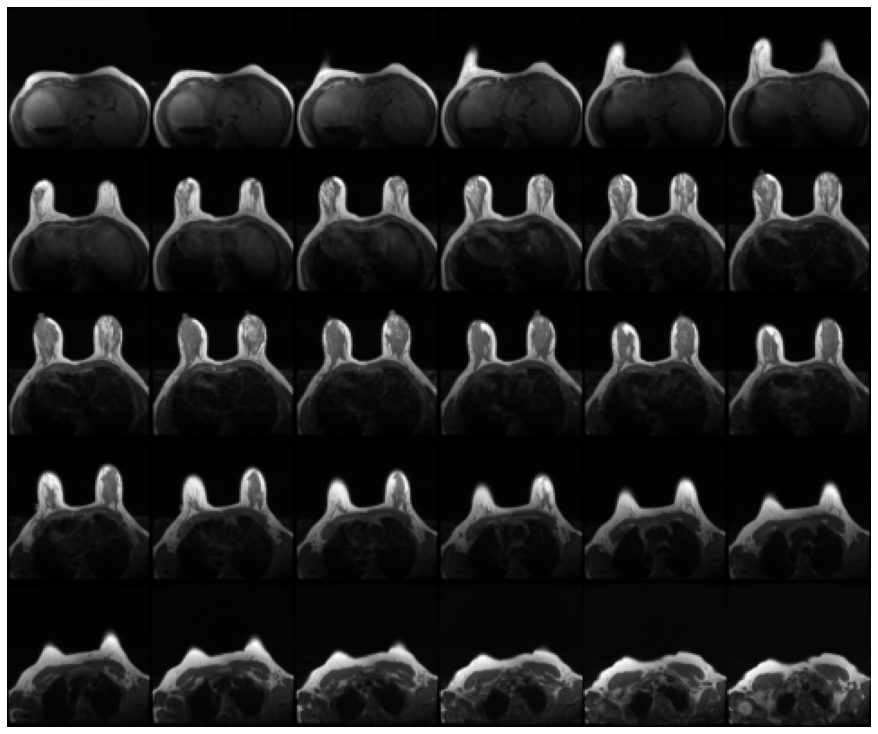

In [6]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = pyplot.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    pyplot.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    pyplot.show()

image = image_nparrays[0]
print("Dimension of 3D image is:", image.shape)

# Visualize montage of slices.
plot_slices(5, 6, 80, 80, image[:, :, :30])

### Step 5. Loading prediction model
>#### Description: 사전에 훈련된 예측모델(모델의 파일이름 변수:model_filename)을 로딩하고 모델의 성능을 평가합니다. 아래 코드를 CTRL + Enter로 실행하십시오.

In [7]:
#load prediction model
model_filename = 'model.unimodal_MRI_TNBC_DFS_3yr.hdf5'
from keras.models import load_model
model = load_model(model_filename)

2023-06-02 14:37:35.975969: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 14:37:36.437769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46274 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6


### Step 6. Perform the predictor
>#### Description: 사용자가 입력한 데이터로 3 year-DFS 예후(low- or high-risk)를 예측합니다. 아래 코드를 CTRL + Enter로 실행하십시오.

In [9]:
#Predicting of risk group of individual
prd_list = np.argmax(model.predict(image_nparrays), axis=1)

for idx in range(len(prd_list)):
    if (prd_list[idx] == 0):
        print("Risk group of", patient_list[idx], ": low-risk in DFS")
    elif (prd_list[idx] == 1):
        print("Risk group of", patient_list[idx], ": high-risk in DFS")

Risk group of Breast_MRI_002 : low-risk in DFS
Risk group of Breast_MRI_002 : low-risk in DFS
Risk group of Breast_MRI_002 : low-risk in DFS
Risk group of Breast_MRI_002 : low-risk in DFS
Risk group of Breast_MRI_002 : low-risk in DFS
Risk group of Breast_MRI_009 : low-risk in DFS
Risk group of Breast_MRI_009 : low-risk in DFS
Risk group of Breast_MRI_009 : low-risk in DFS
Risk group of Breast_MRI_009 : low-risk in DFS
Risk group of Breast_MRI_009 : low-risk in DFS
Risk group of Breast_MRI_010 : high-risk in DFS
Risk group of Breast_MRI_010 : high-risk in DFS
Risk group of Breast_MRI_010 : high-risk in DFS
Risk group of Breast_MRI_010 : high-risk in DFS
Risk group of Breast_MRI_010 : high-risk in DFS
Risk group of Breast_MRI_012 : high-risk in DFS
Risk group of Breast_MRI_012 : high-risk in DFS
Risk group of Breast_MRI_012 : high-risk in DFS
Risk group of Breast_MRI_012 : high-risk in DFS
Risk group of Breast_MRI_012 : high-risk in DFS
Risk group of Breast_MRI_020 : low-risk in DFS
Ris

### Step 7. Estimation of predictive values
>#### Description: 사용자가 입력한 데이터로 예측한 결과에 대해 log-rank test로 생존분석의 통계적 유의성을 검증 합니다.

p =  1.1336410953379218e-147 (by log-rank test)


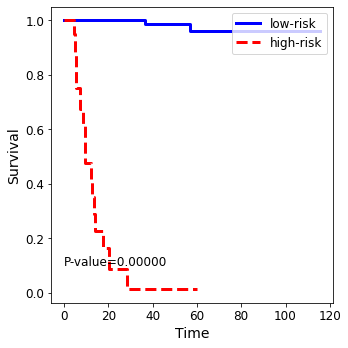

In [19]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from matplotlib import rcParams
import numpy as np

#### 2. labeling from predicted risk group
labels = ['low-risk', 'high-risk']
groups = []
for risk_group in prd_list:
    groups.append(risk_group+1)
events = dfs_list
times  = dfs_m_list

#### 2. preprocessing
E = np.array(events, dtype=np.int32)
T = np.array(times, dtype=np.float32)

#### 3. matplotlib setup
rcParams.update({'font.size': 12})
fig, ax = pyplot.subplots(figsize=(5,5))
styles = ['-', '--']
colors = ['b', 'r']
lw = 3

#### 4. Kaplan-Meier
kmf = KaplanMeierFitter()
for i, label in enumerate(labels):
    ix = np.array(groups) == (i+1)
    kmf.fit(T[ix], event_observed=E[ix], label=labels[i])
    kmf.plot(ax=ax, ci_show=False, linewidth=lw, style=styles[i], c=colors[i])

#### 5. Logrank test
ix = np.array(groups) == 2
result = logrank_test(T[ix], T[~ix], E[ix], E[~ix], alpha=.99)
pvalue = result.p_value
ax.text(0.1, 0.1,'P-value=%.5f'% pvalue)

#### 6. graph setup
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Survival', fontsize=14)
ax.legend(loc='upper right')

#### 7. print & save the graph
print("p = ", pvalue, "(by log-rank test)")
pyplot.tight_layout()
pyplot.savefig('kmplot.png', format='png', dpi=600)
pyplot.show()